In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modeling
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows',5000)
pd.set_option('display.max_columns',None)

In [3]:
X=pd.read_csv('preprocessed_train.csv')
Y=pd.read_csv('preprocessed_train_output.csv')

In [4]:
X.head()

,fti,t3,tsh,tt4
0,-0.070884,-1.296055,-0.254030,-0.279239
1,-0.234985,0.231688,-0.266095,-0.588743
2,-0.070884,-1.296055,-0.121316,-0.320506
3,-1.566025,-1.054833,-0.022384,-1.806129
4,0.567286,-0.170350,-0.269714,0.236603


In [5]:
X_TEST=pd.read_csv('preprocessed_test.csv')
Y_TEST=pd.read_csv('preprocessed_test_output.csv')

In [6]:
X.shape
# Y.shape

(4591, 4)

In [7]:
X_TEST.shape

(1569, 4)

In [8]:
models={
    'KNN classifier': KNeighborsClassifier(),
    'naive bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'xgb': XGBClassifier(),
    'neural_network': MLPClassifier(),
    'adb': AdaBoostClassifier(),
}


params={
    'knn classifier':{'n_neighbors':[3,4,5,6,7], 'weights':['distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']},
    'naive bayes': {},
    'random forest':{'min_samples_split':[21,22,23,24],'criterion':['log_loss','gini','entropy'],'max_features':['sqrt','log2'], 'max_depth':[12]},
    'gradient boost':{'learning_rate':[0.1], 'max_features': ['log2','sqrt'],'n_estimators':[30,31,32,35]},
    'xgb': {'booster': ['gbtree', 'gblinear'], 'learning_rate':[0.1,0.01,0.001],
            'colsample_bylevel':[0.1], 'scale_pos_weight':[1,2],'updater':['grow_colmaker'],
            'gamma':[10,20], 'max_depth':[5,7,9]},
    'neural_network': {'activation':['relu'], 'learning_rate':['constant'], 'learning_rate_init':[0.01,0.1]},
    'adb':{'n_estimators':[10],'learning_rate':[0.1,0.2,0.3, 0.4,0.5]},
}

train_pred_proba=[]
test_pred_proba=[]

for i in range(len(models)):
    gd_cv= GridSearchCV(models[list(models.keys())[i]], param_grid=params[list(params.keys())[i]], scoring='accuracy', cv=3)
    print(f"Dataset shape: {X.shape}")
    
    gd_cv.fit(X,Y)
    
    print("Model:",models[list(models.keys())[i]])
    print("Best Parameters: ",gd_cv.best_params_)
    training_predictions=gd_cv.predict(X)
    train_pred_proba.append(pd.Series(gd_cv.predict_proba(X)[:,1]))
    test_predictions=gd_cv.predict(X_TEST)
    test_pred_proba.append(pd.Series(gd_cv.predict_proba(X_TEST)[:,1]))
    
    
    print(f"Misclassified training features: {(training_predictions!=Y['disease']).sum()}")
    print(f"f1 score: {f1_score(Y, training_predictions,average='macro')}")
    print(f"Classification report: \n{classification_report(Y,training_predictions)}")
    print(f"Roc_auc_score: {roc_auc_score(Y,training_predictions,average='macro')}")
    
    print(f"Misclassified test features: {(test_predictions!=Y_TEST['disease']).sum()}")
    print(f"f1 score: {f1_score(Y_TEST, test_predictions,average='macro')}")
    print(f"Classification report: \n{classification_report(Y_TEST,test_predictions)}")
    print(f"Roc_auc_score: {roc_auc_score(Y_TEST,test_predictions,average='macro')}")
    
    print("=======================================================================================\n")
    
    


Dataset shape: (4591, 4)
Model: KNeighborsClassifier()
Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 6, 'weights': 'distance'}
Misclassified training features: 304
f1 score: 0.9086248526908471
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3505
           1       0.86      0.86      0.86      1086

    accuracy                           0.93      4591
   macro avg       0.91      0.91      0.91      4591
weighted avg       0.93      0.93      0.93      4591

Roc_auc_score: 0.9099238656694068
Misclassified test features: 209
f1 score: 0.7485239477447976
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1294
           1       0.65      0.52      0.58       275

    accuracy                           0.87      1569
   macro avg       0.78      0.73      0.75      1569
weighted avg       0.86      0.87      0.86      1569


[00:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `upda

[00:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `upda

[00:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `upda

[00:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `upda

[00:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.
[00:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:84: DANGER AHEAD: You have manually specified `upda

In [9]:
final_pred=pd.concat(test_pred_proba, axis=1).mean(axis=1)
test_probabilities=pd.concat(test_pred_proba,axis=1)
test_probabilities['mean']=final_pred

In [10]:
test_probabilities.head()

,0,1,2,3,4,5,6,mean
0,0.0,0.713621,0.000000,0.025554,0.460992,0.000010,0.149884,0.192866
1,0.0,0.031382,0.093641,0.057575,0.462830,0.137362,0.149884,0.133239
2,0.0,0.027662,0.002268,0.020333,0.458185,0.048789,0.149884,0.101017
3,0.0,0.023426,0.000000,0.021008,0.457796,0.053593,0.149884,0.100815
4,0.0,0.042652,0.002440,0.021008,0.461845,0.001482,0.149884,0.097044


In [11]:
fpr, tpr, thresholds = roc_curve(Y_TEST, final_pred)

In [12]:
from sklearn.metrics import accuracy_score
accuracy_ls = []
for thres in thresholds:
    y_pred = np.where(final_pred>thres,1,0)
    accuracy_ls.append(accuracy_score(Y_TEST, y_pred, normalize=True))
    
accuracy_ls = pd.concat([pd.Series(thresholds), pd.Series(accuracy_ls)],
                        axis=1)
accuracy_ls.columns = ['thresholds', 'accuracy']
accuracy_ls.sort_values(by='accuracy', ascending=False, inplace=True)
accuracy_ls.head()

,thresholds,accuracy
133,0.498567,0.923518
135,0.492776,0.923518
141,0.485787,0.922881
132,0.499803,0.922881
134,0.494811,0.922881


In [13]:
accuracy_ls

,thresholds,accuracy
133,0.498567,0.923518
135,0.492776,0.923518
141,0.485787,0.922881
132,0.499803,0.922881
134,0.494811,0.922881
136,0.492457,0.922881
137,0.491630,0.922881
142,0.482625,0.922881
152,0.456457,0.922243
151,0.461139,0.922243


In [14]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

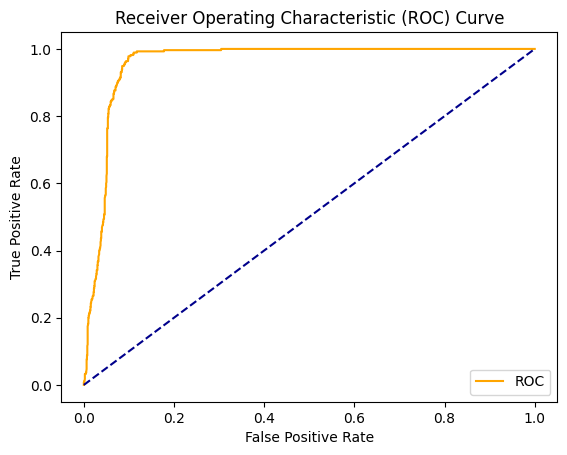

In [15]:
plot_roc_curve(fpr,tpr)

In [16]:
gdb_cls=GradientBoostingClassifier(learning_rate=0.09, max_features='sqrt')

In [17]:
gdb_cls.fit(X,Y)

GradientBoostingClassifier(learning_rate=0.09, max_features='sqrt')

In [18]:
pred=pd.DataFrame(gdb_cls.predict(X_TEST),columns=['Prediction'])

In [19]:
pred['disease']=Y_TEST

In [20]:
pred.head()

,Prediction,disease
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [21]:
print(f"Blunders: {pred[(pred['disease']!=pred['Prediction'])&(pred['disease']==1)].shape[0]}")

Blunders: 29


In [22]:
print(f"Misclassifications: {pred[(pred['disease']!=pred['Prediction'])].shape[0]}")

Misclassifications: 127


In [23]:
filter_pred=pred.copy()

In [24]:
pred_prob=pd.DataFrame(gdb_cls.predict_proba(X_TEST))

In [25]:
filter_pred['Prediction']=np.where(pred_prob[1]<0.34,0,1)

In [26]:
print(f"Blunders: {filter_pred[(filter_pred['disease']!=filter_pred['Prediction'])&(filter_pred['disease']==1)].shape[0]}")

Blunders: 10


In [27]:
print(f"Misclassifications: {filter_pred[(filter_pred['disease']!=filter_pred['Prediction'])].shape[0]}")

Misclassifications: 131


In [28]:
print(classification_report(Y_TEST,filter_pred['Prediction']))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1294
           1       0.69      0.96      0.80       275

    accuracy                           0.92      1569
   macro avg       0.84      0.94      0.87      1569
weighted avg       0.94      0.92      0.92      1569

